## AmirMohammad Ebrahiminasab - Music Genres Classifier

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirebrahiminasab","key":"f5ea3a6c93484c7a343c4382559fb1c5"}'}

In [3]:
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d carlthome/gtzan-genre-collection

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/carlthome/gtzan-genre-collection
License(s): copyright-authors
100% 1.14G/1.14G [00:18<00:00, 98.5MB/s]
100% 1.14G/1.14G [00:18<00:00, 66.6MB/s]


In [4]:
!unzip gtzan-genre-collection.zip

Archive:  gtzan-genre-collection.zip
  inflating: genres/blues/blues.00000.au  
  inflating: genres/blues/blues.00001.au  
  inflating: genres/blues/blues.00002.au  
  inflating: genres/blues/blues.00003.au  
  inflating: genres/blues/blues.00004.au  
  inflating: genres/blues/blues.00005.au  
  inflating: genres/blues/blues.00006.au  
  inflating: genres/blues/blues.00007.au  
  inflating: genres/blues/blues.00008.au  
  inflating: genres/blues/blues.00009.au  
  inflating: genres/blues/blues.00010.au  
  inflating: genres/blues/blues.00011.au  
  inflating: genres/blues/blues.00012.au  
  inflating: genres/blues/blues.00013.au  
  inflating: genres/blues/blues.00014.au  
  inflating: genres/blues/blues.00015.au  
  inflating: genres/blues/blues.00016.au  
  inflating: genres/blues/blues.00017.au  
  inflating: genres/blues/blues.00018.au  
  inflating: genres/blues/blues.00019.au  
  inflating: genres/blues/blues.00020.au  
  inflating: genres/blues/blues.00021.au  
  inflating: genr

### We work on GTZAN dataset which is relatively small dataset and easy to work on.

In [5]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

In [6]:
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
address = "genres"

### Below you can see mel spectogram on 3 different genres of music and as you can see they're not that different from each other, specifically pop and rock.

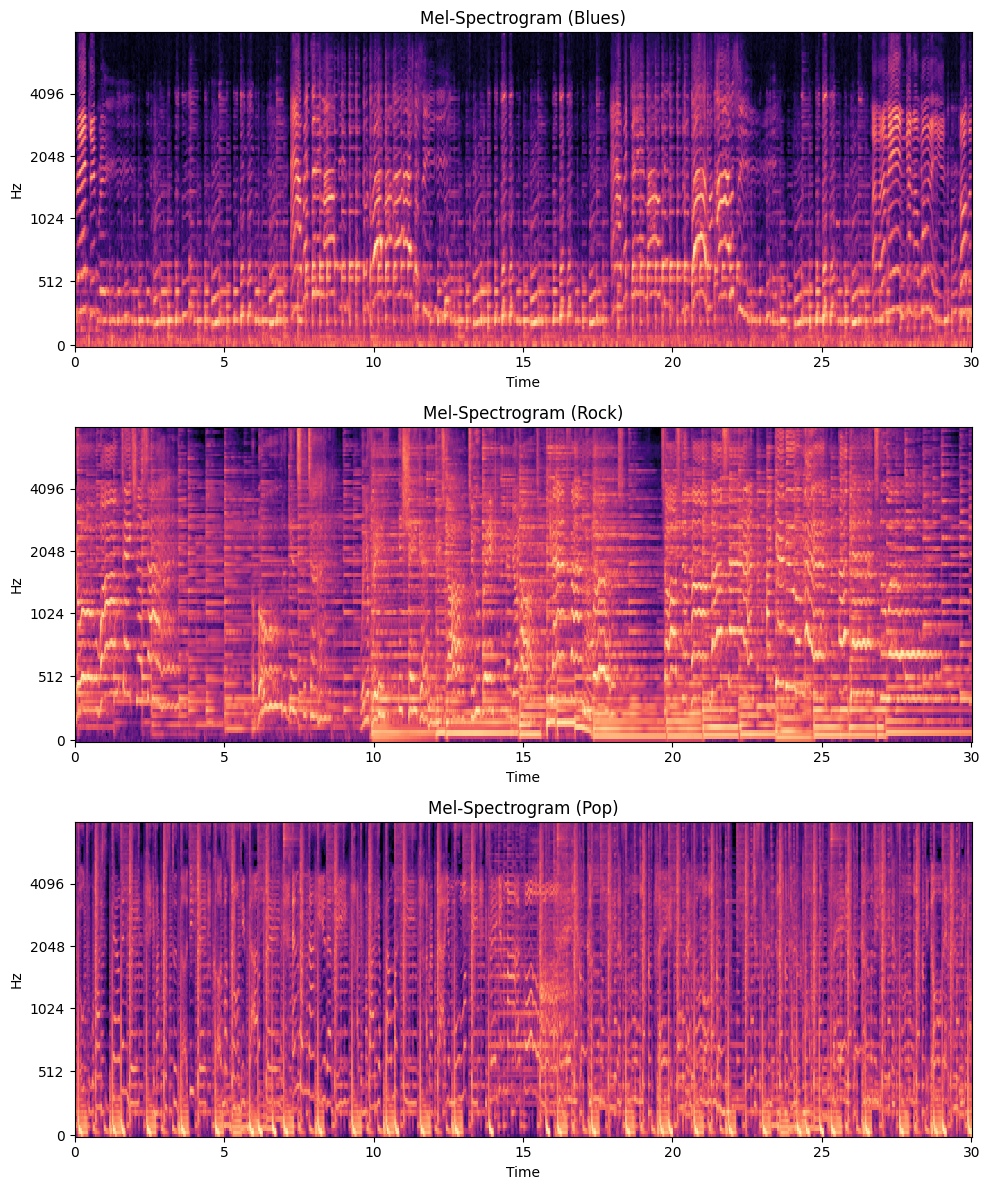

In [7]:
y1, sr1 = librosa.load('genres/blues/blues.00019.au', sr=22050)
y2, sr2 = librosa.load('genres/rock/rock.00085.au', sr=22050)
y3, sr3 = librosa.load('genres/pop/pop.00078.au', sr=22050)

S1 = librosa.feature.melspectrogram(y=y1, sr=sr1, n_mels=128, fmax=8000)
S2 = librosa.feature.melspectrogram(y=y2, sr=sr2, n_mels=128, fmax=8000)
S3 = librosa.feature.melspectrogram(y=y3, sr=sr3, n_mels=128, fmax=8000)

S1_dB = librosa.power_to_db(S1, ref=np.max)
S2_dB = librosa.power_to_db(S2, ref=np.max)
S3_dB = librosa.power_to_db(S3, ref=np.max)

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

librosa.display.specshow(S1_dB, sr=sr1, x_axis='time', y_axis='mel', fmax=8000, ax=axs[0])
axs[0].set_title('Mel-Spectrogram (Blues)')

librosa.display.specshow(S2_dB, sr=sr2, x_axis='time', y_axis='mel', fmax=8000, ax=axs[1])
axs[1].set_title('Mel-Spectrogram (Rock)')

librosa.display.specshow(S3_dB, sr=sr3, x_axis='time', y_axis='mel', fmax=8000, ax=axs[2])
axs[2].set_title('Mel-Spectrogram (Pop)')

plt.tight_layout()
plt.show()


### On the other hand as you can see in mfccs format is much easier to spot the difference between genres as shown below. Hence We pick MFCC format.

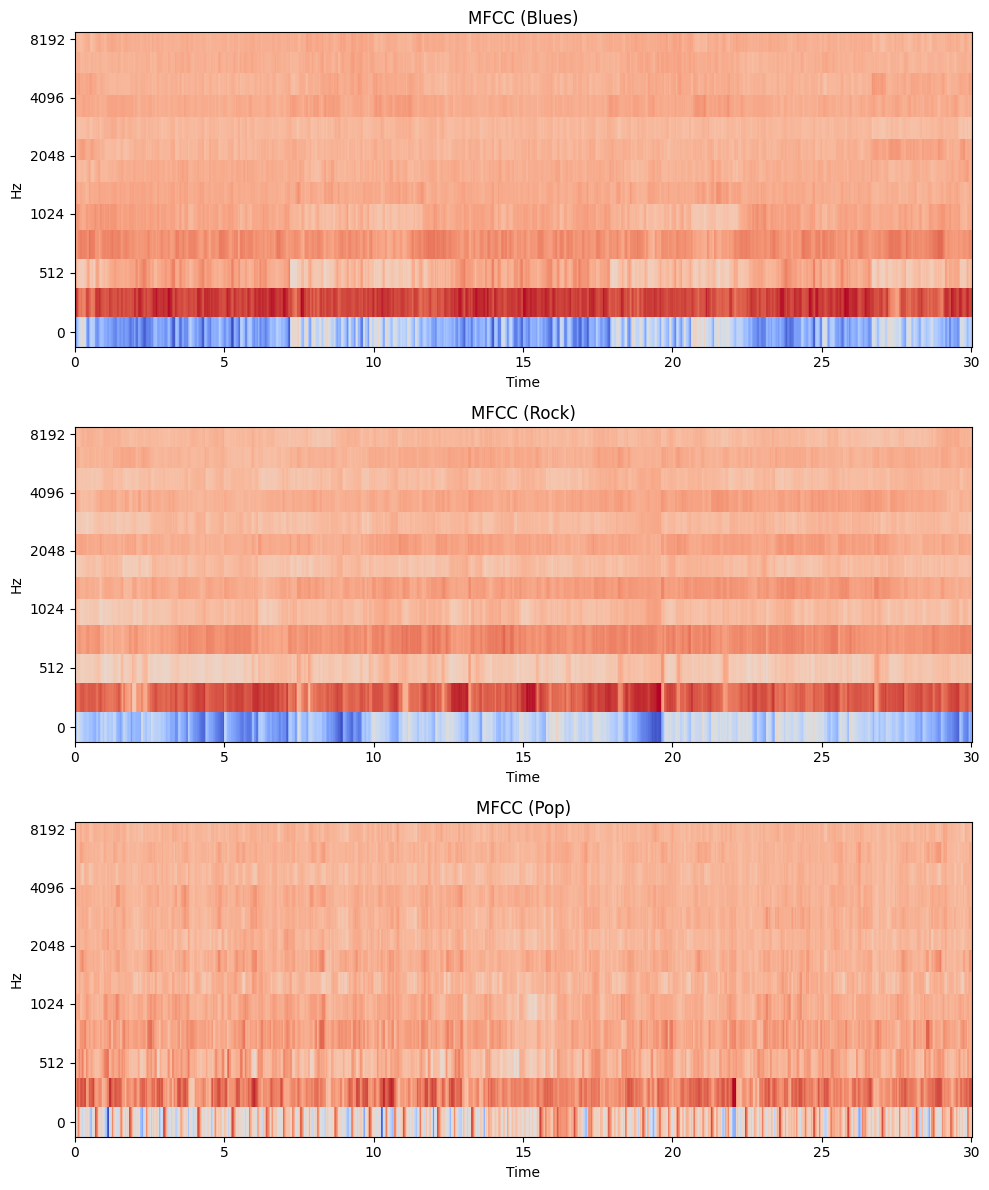

In [90]:
y1, sr1 = librosa.load('genres/blues/blues.00019.au', sr=22050)
y2, sr2 = librosa.load('genres/rock/rock.00085.au', sr=22050)
y3, sr3 = librosa.load('genres/pop/pop.00078.au', sr=22050)

mfccs1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=13)
mfccs2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=13)
mfccs3 = librosa.feature.mfcc(y=y3, sr=sr3, n_mfcc=13)

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

librosa.display.specshow(mfccs1, sr=sr1, x_axis='time', y_axis='mel', fmax=8000, ax=axs[0])
axs[0].set_title('MFCC (Blues)')

librosa.display.specshow(mfccs2, sr=sr2, x_axis='time', y_axis='mel', fmax=8000, ax=axs[1])
axs[1].set_title('MFCC (Rock)')


librosa.display.specshow(mfccs3, sr=sr3, x_axis='time', y_axis='mel', fmax=8000, ax=axs[2])
axs[2].set_title('MFCC (Pop)')

plt.tight_layout()
plt.show()


### So now we extract mfcc and preprocess our dataset.

In [9]:
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs.T

def prepare_dataset(data_path, genres):
    data = {
        "features": [],
        "labels": []
    }

    for i, genre in enumerate(genres):
        genre_path = os.path.join(data_path, genre)
        for file_name in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file_name)
            mfccs = extract_mfcc(file_path)
            if mfccs.shape[0] == 1293:
                data["features"].append(mfccs)
                data["labels"].append(i)

    return np.array(data["features"]), np.array(data["labels"])


In [10]:
X, y = prepare_dataset(address, genres)
X = X[..., np.newaxis]  # Add a channel dimension cause of our CNN structure

y = to_categorical(y, num_classes=len(genres))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
X[0].shape

(1293, 13, 1)

### Here we design our model's structure using CONV2D and MaxPooling2D, and also BatchNormalization for regularization and avoiding overfitting.

### Note that we use soft max activation function at the end, since it's a classification problem.

In [70]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same' , input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(32, (3, 3), padding='same' ,activation='relu'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.6),
    Dense(len(genres), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)                   │ (None, 1293, 13, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 1293, 13, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ (None, 646, 6, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 646, 6, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 646, 6, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ (None, 322, 2, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 322, 2, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 322, 2, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_78 (MaxPooling2D)      │ (None, 161, 1, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_33 (Flatten)                 │ (None, 5152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 64)                  │         329,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,642 (1.33 MB)

 Trainable params: 349,450 (1.33 MB)

 Non-trainable params: 192 (768.00 B)

### Note that the model was trained in 300 epochs, but I've just shown the last half of it.

In [73]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32)

Epoch 1/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7950 - loss: 0.5669 - val_accuracy: 0.5450 - val_loss: 2.6611
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7745 - loss: 0.6241 - val_accuracy: 0.5926 - val_loss: 2.6791
Epoch 3/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7757 - loss: 0.5928 - val_accuracy: 0.5608 - val_loss: 2.5169
Epoch 4/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7807 - loss: 0.6099 - val_accuracy: 0.6190 - val_loss: 2.1588
Epoch 5/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8168 - loss: 0.5216 - val_accuracy: 0.6138 - val_loss: 2.1876
Epoch 6/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8043 - loss: 0.5604 - val_accuracy: 0.6243 - val_loss: 2.4699
Epoch 7/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7778 - loss: 0.5945 - val_accuracy: 0.5503 - val_loss: 2.2235
Epoch 8/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8125 - loss: 0.5668 - val_accuracy: 0.

In [ ]:
# model.save('genre_classification_model.h5')

In [75]:
# from tensorflow.keras.models import load_model

# model = load_model('genre_classification_model.h5')
loss, accuracy = model.evaluate(X_train, y_train)
print(f'Train accuracy: {accuracy * 100:.2f}%')

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9951 - loss: 0.0302
Train accuracy: 99.21%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5806 - loss: 3.7089 
Test accuracy: 63.49%


In [79]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

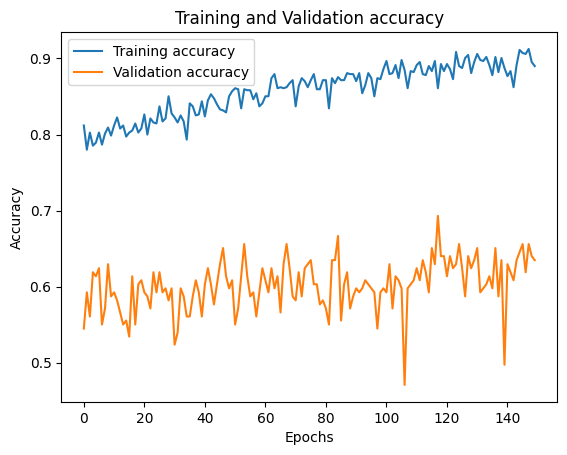

In [81]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

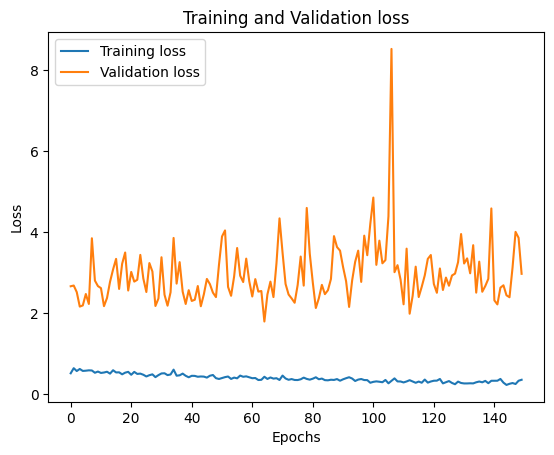

In [83]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [84]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


## As you can see below, model is not capable of recognizing country music, and not really impressive with identifying rock music as well. But as we all know music genres such as rock have so many variant subgenres, which some are really close to blues, country, etc. same logic applies for country music as well.

## What we also can get from the following plot is basically that all pop music is the same 4 chord and sounds the same :)

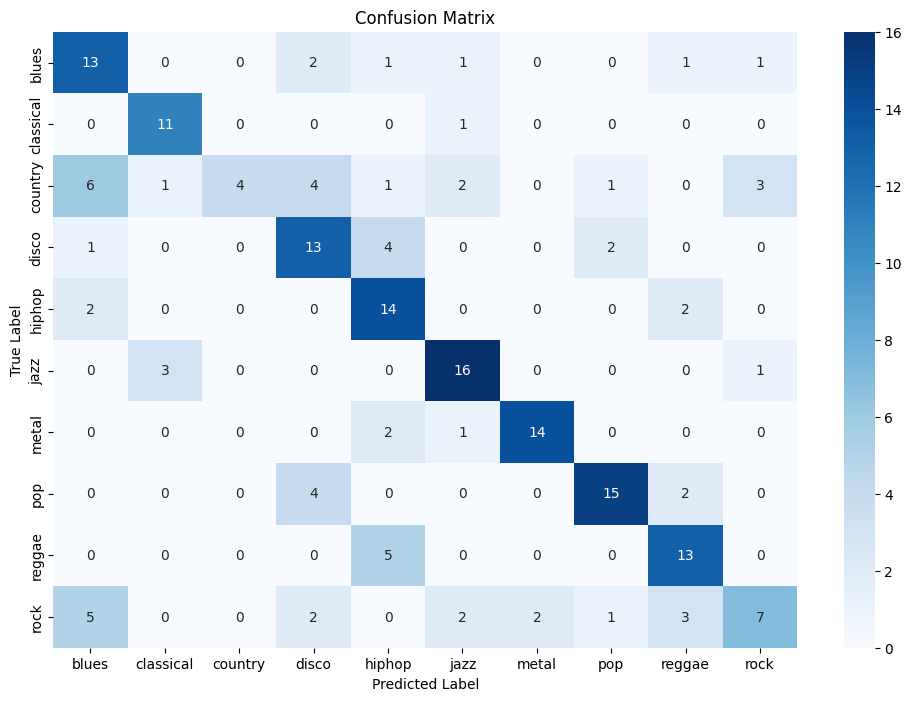

In [89]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()